# Генерация коротких текстов с помощью RNN


__Сделано на основе задания из курса "Deep Learning", HSE__


Генерировать тексты можно с помощью RNN, предсказывающей следующий символ последовательности по предыдущим.

В этом задании предлагается написать и проучить на небольшом датасете имен [генеративную модель на основе символов -- Char-RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Картинку можно посмотреть в [статье Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)

In [2]:
! wget https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2019-spring/seminars/seminar6/names

--2020-07-14 17:46:03--  https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2019-spring/seminars/seminar6/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55869 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.007s  

2020-07-14 17:46:03 (7.12 MB/s) - ‘names’ saved [55869/55869]



В файле `names` находится ~8k имен на латинице.

Модель будет получать на вход имя `Amandy` и выдавать его же, только со сдвигом: `mandy `.

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен, пробел:
```
_Amandy --> Amandy_
```

Для практического использования, на каждом шаге будем подавать на вход букву, предсказанную на предыдущем.
Так что нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов).
С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный `<EOS>` токен. В данном случае обозначим его `#`:

```
_Amandy --> Amandy#
```

Будем прекращать генерацию при досрочном выпадании `<EOS>`.

In [3]:
import os
start_token = " "
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
 Maggy#
 Hershel#
 Kenneth#
 Darda#
 Amelia#
 Emelyne#
 Sandor#
 Katrinka#


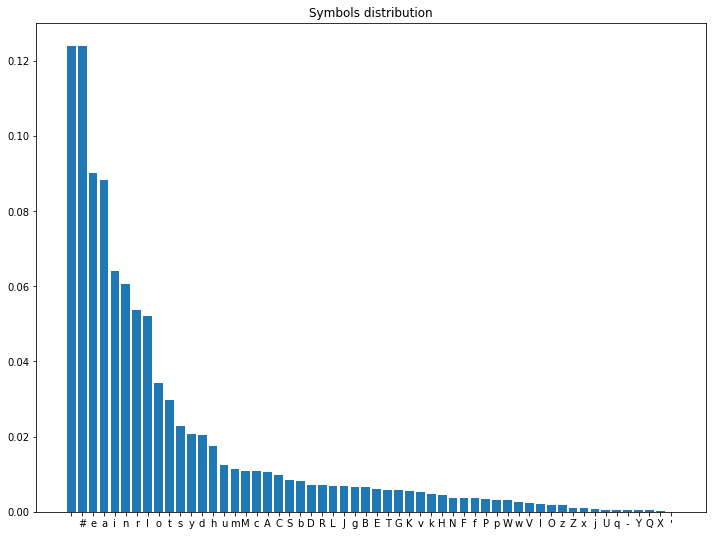

In [5]:
# TODO: постройте частоты употреблений букв

from collections import Counter
cnt = Counter()

for name in names:
    cnt.update(name)

plt.figure(figsize=(12, 9))
plt.title('Symbols distribution')

counts = sorted(cnt.items(), key=lambda t: -t[1]) # from max to min by frequency

symbols, y = list(zip(*counts))
x = np.arange(len(y))
y = np.array(y)
y = y/np.sum(y)
plt.bar(x, y)
plt.xticks(x, symbols)
plt.show()
# для графика используйте plt.bar

max length = 17


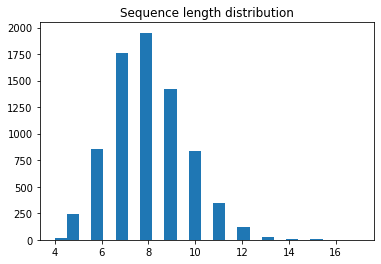

In [6]:
# датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [7]:
names[:10]

[' Maggy#',
 ' Vivia#',
 ' Barnard#',
 ' Verene#',
 ' Lionel#',
 ' Jacquette#',
 ' Diena#',
 ' Elana#',
 ' Cam#',
 ' Cleo#']

In [8]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы пробел имел номер 0


# counts = sorted(cnt.items(), key=lambda t: -t[1])
# counts = # from max to min by frequency

tokens = [t[0] for t in counts]
tokens.sort() # check influence to rnn training

tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for tok, i in tok2id.items()}


n_tokens = len(tokens)
print (f'There are {n_tokens} tokens')

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 56 tokens
Vocabular:  #'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [9]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [11]:
max(map(len, names))

17

In [10]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

 Maggy#
 Vivia#
 Barnard#
 Verene#
 Lionel#
 Jacquette#
 Diena#
 Elana#
 Cam#
 Cleo#
[[ 0 16 30 36 36 54  1  0  0  0  0]
 [ 0 25 38 51 38 30  1  0  0  0  0]
 [ 0  5 30 47 43 30 47 33  1  0  0]
 [ 0 25 34 47 34 43 34  1  0  0  0]
 [ 0 15 38 44 43 34 41  1  0  0  0]
 [ 0 13 30 32 46 50 34 49 49 34  1]
 [ 0  7 38 34 43 30  1  0  0  0  0]
 [ 0  8 41 30 43 30  1  0  0  0  0]
 [ 0  6 30 42  1  0  0  0  0  0  0]
 [ 0  6 41 34 44  1  0  0  0  0  0]]


In [12]:
def split_data(names, ratio=0.2):
    idx = np.arange(len(names))
    num_v = int(ratio * len(names))
    x = np.array(names)    
    return x[idx[num_v:]], x[idx[:num_v]]
    
train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6063, 1515)

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output


torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

# Char-RNN для имен

Вам нужно написать сеть, кодирующую номера входных символов с помощью таблицы Embeddings. 
Получившиеся тензоры пропустить через RNN ячейку, затем преобразовать в логиты для предсказания номера нового символа.

In [24]:
# NB: обратите внимание на порядок осей при вызове forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# Сделайте возможность выбора типа ячейки, RNN, GRU или LSTM
# TODO: заполните пропуски. Функция forward будет вызываться на каждый шаг нами

class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="rnn", n_layers=1):
        super(NameRNN, self).__init__()
        # добавьте возможность выбрать тип ячейки RNN/LSTM
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.cell_type = cell

        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        available_cells = {'rnn': nn.RNN(hidden_size, hidden_size, 
                                         num_layers=n_layers),
                            'lstm': nn.LSTM(hidden_size, hidden_size,
                                            num_layers=n_layers),
                            'gru' : None
                            }
        self.rnn = available_cells[self.cell_type]
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        bs = inputs.size(0)
        
        embedded = self.embeddings(inputs)
        reordered = embedded.view(1, bs, -1)
        
        output, hidden = self.rnn(reordered, hidden)
        out = self.decoder(output)
        return out.view(bs, -1), hidden

    def init_hidden(self, batch_size):
        if self.cell_type == 'lstm':
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True), 
                     torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True))
            
        return torch.zeros(self.n_layers, batch_size, 
                           self.hidden_size, requires_grad=True)


# Код для тренировки RNN

In [19]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        # можно вынести подсчет ошибки в модельку
        
        nums = to_matrix(batch)
        t = torch.from_numpy(nums)
        
        hidden = model.init_hidden(t.shape[0])
        optimizer.zero_grad()
        
        loss = 0.0
        for i in range(0, t.shape[1] - 1):
            out, hidden = model(t[:, i], hidden)
            loss += F.cross_entropy(out, t[:, i+1])
            # по хорошему, надо маскировать подсчет ошибки
            # чтобы градиенты не разливались за отступы
            # плюс, поскольку есть имена с пробелами посередине (правда мало)
            # стоит выбрать другой символ для отступов
        
        loss.backward()
        optimizer.step()
        loss = loss.item() # tensor(10).item() = 10
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        
        nums = to_matrix(batch)
        t = torch.from_numpy(nums)
        
        hidden = model.init_hidden(t.shape[0])
        loss = 0.0
        for i in range(0, t.shape[1] - 1):
            out, hidden = model(t[:, i], hidden)
            loss += F.cross_entropy(out, t[:, i+1])

        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

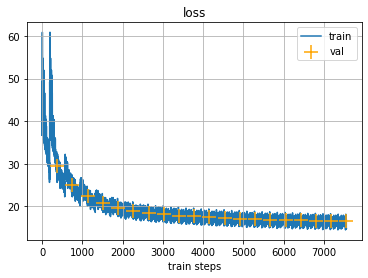

In [26]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='rnn', n_layers=2)

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

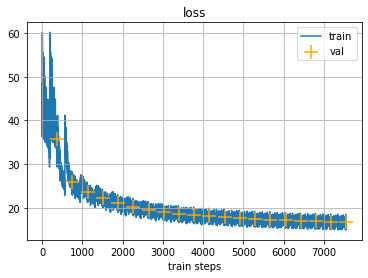

In [25]:
lstm_net = NameRNN(len(tokens), 50, len(tokens), cell='lstm')

opt = torch.optim.Adam(lstm_net.parameters(), lr=1e-4)
train(lstm_net, opt, 20)

# Жадная Генерация

In [27]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return logits.max(dim=1)[1]

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)

def gen_continuation(model, prefix=" "):
    hidden = model.init_hidden(1)
    nums = to_matrix(prefix)
    nums = torch.from_numpy(nums)
    for inp in nums:
        out, hidden = model.forward(inp, hidden)
    inp = pick_by_argmax(out)
    
    outs = [inp.item()]
    for i in range(10):
        out, hidden = model.forward(inp, hidden)
        inp = pick_by_argmax(out)
        outs.append(inp.item())
        
    print(prefix + '|'+ ids2string(outs))

In [31]:
gen_continuation(rnn, " Ber")

 Ber|lie#       


# Генерация с семплированием

Обычный софтмакс 
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
можно модернизировать с помощью температуры:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

Это позволит плавно переходить от выбора наиболее вероятного элемента ($T << 1$) до практически равновероятного ($T >> 1$)


In [48]:
torch.multinomial(torch.tensor([0.1, 0.4, 0.3, 0.2]), 1)

tensor([0])

In [51]:
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2numpy(tt):
    return tt.numpy()
    
def batch2string(ids, prefix):
    # в массиве есть лишняя размерность, поэтому сначала схлопнем.
    ids = np.array(ids).squeeze(axis=0)
    sh = ids.shape
    chars = np.array([id2tok[_] for _ in ids.flatten()]).reshape(sh)
    return "\n".join(prefix + "".join(line) for line in chars)

def pick_by_distribution(logits):
    probs = F.softmax(logits, -1)
    sample = torch.multinomial(probs, 1)
    return sample

def gen_continuation_temp(model, prefix=" ", temperature=1.0, n=10):
    hidden = model.init_hidden(n)
    nums = to_matrix([prefix] * n)
    nums = torch.from_numpy(nums)

     # аналогично, сначала получите батч output, hidden
    for i in range(len(prefix)):
        inp = nums[:, i]
        out, hidden = model.forward(inp, hidden)
    
    
    # затем, сгенерируйте n последующих символов
    # в outs положите матрицу номеров токенов и отобразите ее
    inp = pick_by_distribution(out / temperature)
    outs = [batch2numpy(inp)]
    for i in range(10):
        out, hidden = model.forward(inp, hidden)
        inp = pick_by_distribution(out/temperature)
        outs.append(batch2numpy(inp))
    outs = np.array(outs).transpose()
    print(batch2string(outs, prefix + '|'))

In [80]:
gen_continuation_temp(lstm_net, prefix=" Ann", temperature=0.5, n=10)

 Ann|ena#       
 Ann|a#         
 Ann|eta#       
 Ann|an#        
 Ann|d#         
 Ann|al#        
 Ann|ar#        
 Ann|ana#       
 Ann|e#         
 Ann|ele#       


In [71]:
gen_continuation_temp(lstm_net, prefix=" Al", temperature=1e-10, n=1)

 Al|ine#       


In [67]:
gen_continuation_temp(lstm_net, prefix=" Al", temperature=1e-1, n=1)

 Al|ina#       
